---
format:
  html:
   code-fold: true
   code-summary: "Show the code"
   toc: true
   page-layout: full
jupyter: Python3

---

# 4 - Street Networks & Web Scraping

**Part 1: Visualizing crash data in Philadelphia**

In this section, you will use `osmnx` to analyze the crash incidence in Center City. 


**Part 2: Scraping Craigslist**

In this section, you will use Selenium and BeautifulSoup to scrape data for hundreds of apartments from Philadelphia's Craigslist portal.


In [21]:
import pandas as pd
import geopandas as gpd
import altair as alt
import numpy as np
from matplotlib import pyplot as plt
np.seterr(invalid="ignore");
from shapely import geometry

## Part 1: Visualizing crash data in Philadelphia

### 1.1 Load the geometry for the region being analyzed

We'll analyze crashes in the "Central" planning district in Philadelphia, a rough approximation for Center City. [Planning districts](https://www.opendataphilly.org/dataset/planning-districts) can be loaded from Open Data Philly. Read the data into a GeoDataFrame using the following link:

[http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson](http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson)

Select the "Central" district and extract the geometry polygon for only this district. After this part, you should have a polygon variable of type `shapely.geometry.polygon.Polygon`.

In [87]:
url = "http://data.phl.opendata.arcgis.com/datasets/0960ea0f38f44146bb562f2b212075aa_0.geojson"
philly_districts = gpd.read_file(url).to_crs('EPSG:4326')
central = philly_districts.loc[philly_districts['DIST_NAME'] == 'Central']

polygon = central['geometry'].iloc[0]
print(type(polygon))

<class 'shapely.geometry.polygon.Polygon'>


### 1.2 Get the street network graph

Use OSMnx to create a network graph (of type 'drive') from your polygon boundary in 1.1.

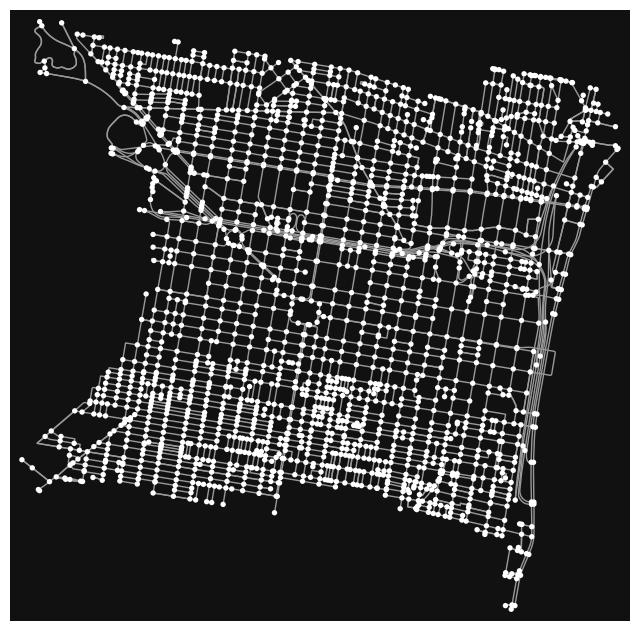

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [88]:
import osmnx as ox
graph = ox.graph_from_polygon(polygon, network_type='drive')
philly_graph = ox.project_graph(graph)
ox.plot_graph(philly_graph)

### 1.3 Convert your network graph edges to a GeoDataFrame

Use OSMnx to create a GeoDataFrame of the network edges in the graph object from part 1.2. The GeoDataFrame should contain the edges but not the nodes from the network.

In [89]:
edges = ox.graph_to_gdfs(philly_graph, edges=True, nodes=False).to_crs('EPSG:4326')
edges.head()

osmid  oneway                   name  \
u         v         key                                             
109727439 109911666 0    132508434    True      Bainbridge Street   
109911666 109911655 0    132508434    True      Bainbridge Street   
          110024009 0     12139665    True      South 17th Street   
109727448 109727439 0     12109011    True  South Colorado Street   
          110034229 0     12159387    True       Fitzwater Street   

                             highway reversed   length  \
u         v         key                                  
109727439 109911666 0    residential    False   44.137   
109911666 109911655 0    residential    False   45.459   
          110024009 0       tertiary    False  109.692   
109727448 109727439 0    residential    False  109.484   
          110034229 0    residential    False   91.353   

                                                                  geometry  \
u         v         key                                                      
109727439 109911666 0    LINESTRING (-75.17104 39.94345, -75.17053 39.9...   
109911666 109911655 0    LINESTRING (-75.17053 39.94339, -75.17001 39.9...   
          110024009 0    LINESTRING (-75.17053 39.94339, -75.17060 39.9...   
109727448 109727439 0    LINESTRING (-75.17125 39.94248, -75.17120 39.9...   
          110034229 0    LINESTRING (-75.17125 39.94248, -75.17137 39.9...   

                        maxspeed lanes tunnel bridge  ref width service  \
u         v         key                                                   
109727439 109911666 0        NaN   NaN    NaN    NaN  NaN   NaN     NaN   
109911666 109911655 0        NaN   NaN    NaN    NaN  NaN   NaN     NaN   
          110024009 0        NaN   NaN    NaN    NaN  NaN   NaN     NaN   
109727448 109727439 0        NaN   NaN    NaN    NaN  NaN   NaN     NaN   
          110034229 0        NaN   NaN    NaN    NaN  NaN   NaN     NaN   

                        access junction  
u         v         key                  
109727439 109911666 0      NaN      NaN  
109911666 109911655 0      NaN      NaN  
          110024009 0      NaN      NaN  
109727448 109727439 0      NaN      NaN  
          110034229 0      NaN      NaN

In [94]:
edges.explore()

### 1.4 Load PennDOT crash data

Data for crashes (of all types) for 2020, 2021, and 2022 in Philadelphia County is available at the following path:

`./data/CRASH_PHILADELPHIA_XXXX.csv`

You should see three separate files in the `data/` folder. Use pandas to read each of the CSV files, and combine them into a single dataframe using `pd.concat()`.

The data was downloaded for Philadelphia County [from here](https://crashinfo.penndot.gov/PCIT/welcome.html).

In [6]:
crash_2020 = pd.read_csv("./data/CRASH_PHILADELPHIA_2020.csv")
crash_2021 = pd.read_csv("./data/CRASH_PHILADELPHIA_2021.csv")
crash_2022 = pd.read_csv("./data/CRASH_PHILADELPHIA_2022.csv")

In [9]:
philly_crash = pd.concat([crash_2020, crash_2021, crash_2020])
philly_crash

CRN  ARRIVAL_TM  AUTOMOBILE_COUNT  BELTED_DEATH_COUNT  \
0      2020036588      1349.0                 1                   0   
1      2020036617      1842.0                 1                   0   
2      2020035717      2000.0                 1                   0   
3      2020034378      1139.0                 2                   0   
4      2020025511       345.0                 1                   0   
...           ...         ...               ...                 ...   
10160  2020107585      2159.0                 1                   0   
10161  2020109081      1945.0                 2                   0   
10162  2020108478       537.0                 1                   0   
10163  2020108480      2036.0                 2                   0   
10164  2020110361      1454.0                 0                   0   

       BELTED_SUSP_SERIOUS_INJ_COUNT  BICYCLE_COUNT  BICYCLE_DEATH_COUNT  \
0                                  0              0                    0   
1                                  0              0                    0   
2                                  0              0                    0   
3                                  0              0                    0   
4                                  0              0                    0   
...                              ...            ...                  ...   
10160                              0              0                    0   
10161                              0              0                    0   
10162                              0              0                    0   
10163                              0              0                    0   
10164                              0              0                    0   

       BICYCLE_SUSP_SERIOUS_INJ_COUNT  BUS_COUNT  CHLDPAS_DEATH_COUNT  ...  \
0                                   0          0                    0  ...   
1                                   0          0                    0  ...   
2                                   0          0                    0  ...   
3                                   0          0                    0  ...   
4                                   0          0                    0  ...   
...                               ...        ...                  ...  ...   
10160                               0          0                    0  ...   
10161                               0          0                    0  ...   
10162                               0          0                    0  ...   
10163                               0          0                    0  ...   
10164                               0          0                    0  ...   

       WORK_ZONE_TYPE  WORKERS_PRES  WZ_CLOSE_DETOUR  WZ_FLAGGER  \
0                 NaN           NaN              NaN         NaN   
1                 NaN           NaN              NaN         NaN   
2                 NaN           NaN              NaN         NaN   
3                 NaN           NaN              NaN         NaN   
4                 NaN           NaN              NaN         NaN   
...               ...           ...              ...         ...   
10160             NaN           NaN              NaN         NaN   
10161             NaN           NaN              NaN         NaN   
10162             NaN           NaN              NaN         NaN   
10163             NaN           NaN              NaN         NaN   
10164             NaN           NaN              NaN         NaN   

       WZ_LAW_OFFCR_IND  WZ_LN_CLOSURE  WZ_MOVING  WZ_OTHER  WZ_SHLDER_MDN  \
0                   NaN            NaN        NaN       NaN            NaN   
1                   NaN            NaN        NaN       NaN            NaN   
2                   NaN            NaN        NaN       NaN            NaN   
3                   NaN            NaN        NaN       NaN            NaN   
4                   NaN            NaN        NaN       NaN            NaN   
...                 ...   

### 1.5 Convert the crash data to a GeoDataFrame

You will need to use the `DEC_LAT` and `DEC_LONG` columns for latitude and longitude.

The full data dictionary for the data is [available here](http://pennshare.maps.arcgis.com/sharing/rest/content/items/ffe20c6c3c594389b275c6772a281bcd/data)

In [78]:
crash_geo = gpd.GeoDataFrame(philly_crash, geometry=gpd.points_from_xy(philly_crash.DEC_LONG, philly_crash.DEC_LAT), crs="EPSG:4326")

### 1.6 Trim the crash data to Center City

1. Get the boundary of the edges data frame (from part 1.3). Accessing the `.geometry.unary_union.convex_hull` property will give you a nice outer boundary region.
1. Trim the crashes using the `within()` function of the crash GeoDataFrame to find which crashes are within the boundary.

There should be about 3,750 crashes within the Central district.

In [90]:
boundary = edges.geometry.unary_union.convex_hull

central_crash = crash_geo[crash_geo.within(boundary)]
central_crash

CRN  ARRIVAL_TM  AUTOMOBILE_COUNT  BELTED_DEATH_COUNT  \
0      2020036588      1349.0                 1                   0   
7      2020035021      1255.0                 1                   0   
11     2020021944       805.0                 2                   0   
12     2020024963      1024.0                 1                   0   
18     2020000481      1737.0                 1                   0   
...           ...         ...               ...                 ...   
10132  2020105944      1841.0                 0                   0   
10133  2020112963      2052.0                 2                   0   
10148  2020111219      1324.0                 0                   0   
10150  2020110378      2025.0                 6                   0   
10161  2020109081      1945.0                 2                   0   

       BELTED_SUSP_SERIOUS_INJ_COUNT  BICYCLE_COUNT  BICYCLE_DEATH_COUNT  \
0                                  0              0                    0   
7                                  0              0                    0   
11                                 0              0                    0   
12                                 0              0                    0   
18                                 0              0                    0   
...                              ...            ...                  ...   
10132                              0              0                    0   
10133                              0              0                    0   
10148                              0              0                    0   
10150                              0              0                    0   
10161                              0              0                    0   

       BICYCLE_SUSP_SERIOUS_INJ_COUNT  BUS_COUNT  CHLDPAS_DEATH_COUNT  ...  \
0                                   0          0                    0  ...   
7                                   0          1                    0  ...   
11                                  0          0                    0  ...   
12                                  0          0                    0  ...   
18                                  0          1                    0  ...   
...                               ...        ...                  ...  ...   
10132                               0          0                    0  ...   
10133                               0          0                    0  ...   
10148                               0          0                    0  ...   
10150                               0          0                    0  ...   
10161                               0          0                    0  ...   

       WORKERS_PRES  WZ_CLOSE_DETOUR  WZ_FLAGGER  WZ_LAW_OFFCR_IND  \
0               NaN              NaN         NaN               NaN   
7               NaN              NaN         NaN               NaN   
11              NaN              NaN         NaN               NaN   
12              NaN              NaN         NaN               NaN   
18              NaN              NaN         NaN               NaN   
...             ...              ...         ...               ...   
10132           NaN              NaN         NaN               NaN   
10133           NaN              NaN         NaN               NaN   
10148           NaN              NaN         NaN               NaN   
10150           NaN              NaN         NaN               NaN   
10161           NaN              NaN         NaN               NaN   

       WZ_LN_CLOSURE  WZ_MOVING  WZ_OTHER  WZ_SHLDER_MDN  \
0                NaN        NaN       NaN            NaN   
7                NaN        NaN       NaN            NaN   
11               NaN        NaN       NaN            NaN   
12               NaN        NaN       NaN            NaN   
18               NaN        NaN       NaN            NaN   
...              ...        ...       ...            ...   
10132            NaN        NaN       NaN         

### 1.7 Re-project our data into an approriate CRS

We'll need to find the nearest edge (street) in our graph for each crash. To do this, `osmnx` will calculate the distance from each crash to the graph edges. For this calculation to be accurate, we need to convert from latitude/longitude 

**We'll convert the local state plane CRS for Philadelphia, EPSG=2272**

#### Two steps:
1. Project the graph object (`G`) using the `ox.project_graph`. Run `ox.project_graph?` to see the documentation for how to convert to a specific CRS. 
1. Project the crash data using the `.to_crs()` function.

In [96]:
philly_G = ox.project_graph(philly_graph, to_crs='EPSG:2272')

In [93]:
central_crash = central_crash.to_crs('EPSG:2272')

### 1.8 Find the nearest edge for each crash

See: `ox.distance.nearest_edges()`. It takes three arguments:

- the network graph
- the longitude of your crash data (the `x` attribute of the `geometry` column)
- the latitude of your crash data (the `y` attribute of the `geometry` column)

You will get a numpy array with 3 columns that represent `(u, v, key)` where each `u` and `v` are the node IDs that the edge links together. We will ignore the `key` value for our analysis.

In [100]:
nearest_crash = ox.distance.nearest_edges(philly_G, central_crash['geometry'].x, central_crash['geometry'].y)

### 1.9 Calculate the total number of crashes per street

1. Make a DataFrame from your data from part 1.7 with three columns, `u`, `v`, and `key` (we will only use the `u` and `v` columns)
1. Group by `u` and `v` and calculate the size
1. Reset the index and name your `size()` column as `crash_count`

After this step you should have a DataFrame with three columns: `u`, `v`, and `crash_count`.

In [108]:
nearest_Crash = pd.DataFrame(nearest_crash, columns=['u', 'v', 'key'])

In [111]:
crash_counts = nearest_Crash.groupby(['u', 'v']).count().reset_index()
crash_counts = crash_counts.rename(columns={'key': 'crash_count'})
crash_counts

u            v  crash_count
0      109729474   3425014859            2
1      109729486    110342146            4
2      109729699    109811674           10
3      109729709    109729731            3
4      109729731    109729739            6
..           ...          ...          ...
729  10270051289   5519334546            1
730  10660521823  10660521817            2
731  10674041689  10674041689           14
732  11144117753    109729699            4
733  11162290432    110329835            1

[734 rows x 3 columns]

### 1.10 Merge your edges GeoDataFrame and crash count DataFrame

You can use pandas to merge them on the `u` and `v` columns. This will associate the total crash count with each edge in the street network. 

**Tips:** 
   - Use a `left` merge where the first argument of the merge is the edges GeoDataFrame. This ensures no edges are removed during the merge.
   - Use the `fillna(0)` function to fill in missing crash count values with zero.

In [150]:
merged = pd.merge(edges, crash_counts, on=['u','v'], how='left').fillna(0)
merged.head()


u          v      osmid  oneway                   name  \
0  109727439  109911666  132508434    True      Bainbridge Street   
1  109911666  109911655  132508434    True      Bainbridge Street   
2  109911666  110024009   12139665    True      South 17th Street   
3  109727448  109727439   12109011    True  South Colorado Street   
4  109727448  110034229   12159387    True       Fitzwater Street   

       highway reversed   length  \
0  residential    False   44.137   
1  residential    False   45.459   
2     tertiary    False  109.692   
3  residential    False  109.484   
4  residential    False   91.353   

                                            geometry maxspeed lanes tunnel  \
0  LINESTRING (-75.17104 39.94345, -75.17053 39.9...        0     0      0   
1  LINESTRING (-75.17053 39.94339, -75.17001 39.9...        0     0      0   
2  LINESTRING (-75.17053 39.94339, -75.17060 39.9...        0     0      0   
3  LINESTRING (-75.17125 39.94248, -75.17120 39.9...        0     0      0   
4  LINESTRING (-75.17125 39.94248, -75.17137 39.9...        0     0      0   

  bridge ref width service access junction  crash_count  
0      0   0     0       0      0        0          0.0  
1      0   0     0       0      0        0          0.0  
2      0   0     0       0      0        0          0.0  
3      0   0     0       0      0        0          0.0  
4      0   0     0       0      0        0          0.0

### 1.11 Calculate a "Crash Index"

Let's calculate a "crash index" that provides a normalized measure of the crash frequency per street. To do this, we'll need to:

1. Calculate the total crash count divided by the street length, using the `length` column
1. Perform a log transformation of the crash/length variable — use numpy's `log10()` function
1. Normalize the index from 0 to 1 (see the lecture notes for an example of this transformation)

**Note: since the crash index involves a log transformation, you should only calculate the index for streets where the crash count is greater than zero**.

After this step, you should have a new column in the data frame from 1.9 that includes a column called part 1.9.

In [160]:
merge_dropna = merged[merged['crash_count'] != 0]

In [169]:
calculation = np.log10(merge_dropna['crash_count']/merge_dropna['length'])
#(np.log10(merged['crash_count']/merged['length']) - np.log10(merged['crash_count']/merged['length']).min())/ (np.log10(merged['crash_count']/merged['length']).max() - np.log10(merged['crash_count']/merged['length']).min())
merge_dropna['crash index'] = (calculation - calculation.min())/(calculation.max() - calculation.min())
merge_dropna.head(5)

/Users/annzhang/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


u           v                              osmid  oneway  \
9    110024052   110024066                           12139665    True   
30   109729474  3425014859                           62154356    True   
31   109729486   110342146             [12169305, 1052694387]    True   
33  3425014859  5372059859  [12197696, 1003976882, 424804083]    True   
35   110342146   315655546              [424807270, 12109183]    True   

                            name        highway reversed   length  \
9              South 17th Street       tertiary    False  135.106   
30                   Arch Street      secondary    False  126.087   
31  North Independence Mall East      secondary    False  123.116   
33  North Independence Mall West      secondary    False  229.386   
35                             0  motorway_link    False  153.933   

                                             geometry maxspeed   lanes tunnel  \
9   LINESTRING (-75.17134 39.93966, -75.17152 39.9...        0       0      0   
30  LINESTRING (-75.14847 39.95259, -75.14859 39.9...   25 mph       2      0   
31  LINESTRING (-75.14832 39.95333, -75.14813 39.9...        0  [3, 2]      0   
33  LINESTRING (-75.14993 39.95277, -75.14995 39.9...        0       3      0   
35  LINESTRING (-75.14809 39.95442, -75.14808 39.9...        0       1      0   

   bridge ref width service access junction  crash_count  crash index  
9       0   0     0       0      0        0          9.0     0.431858  
30      0   0     0       0      0        0          2.0     0.258123  
31      0   0     0       0      0        0          4.0     0.344930  
33      0   0     0       0      0        0          2.0     0.185670  
35      0   0     0       0      0        0          3.0     0.283054

### 1.12 Plot a histogram of the crash index values

Use matplotlib's `hist()` function to plot the crash index values from the previous step.

You should see that the index values are Gaussian-distributed, providing justification for why we log-transformed!

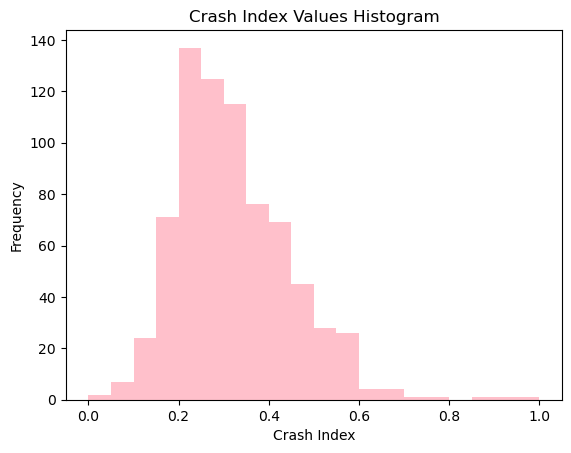

In [177]:
plt.hist(merge_dropna['crash index'], color='pink', bins=20)

plt.xlabel('Crash Index')
plt.ylabel('Frequency')
plt.title('Crash Index Values Histogram')
plt.show()

### 1.13 Plot an interactive map of the street networks, colored by the crash index

You can use GeoPandas to make an interactive Folium map, coloring the streets by the crash index column.

**Tip:** if you use the viridis color map, try using a "dark" tile set for better constrast of the colors.

In [186]:
crash_index = merge_dropna[['u', 'v', 'crash index']]
merged_index = pd.merge(merged, crash_index, on=['u','v'], how='left').fillna(0)

In [193]:
merged_index.explore(
    column="crash index",
    cmap="YlGnBu",
    tiles="cartodbpositron",)

## Part 2: Scraping Craigslist

In this part, we'll be extracting information on apartments from Craigslist search results. You'll be using Selenium and BeautifulSoup to extract the relevant information from the HTML text. 

For reference on CSS selectors, please see the [notes from Week 6](https://github.com/MUSA-550-Fall-2022/week-6/blob/main/css-selectors.md).

### Primer: the Craigslist website URL

We'll start with the Philadelphia region. First we need to figure out how to submit a query to Craigslist. As with many websites, one way you can do this is simply by constructing the proper URL and sending it to Craigslist. 

[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0)

There are **three** components to this URL. 

1. The base URL: `http://philadelphia.craigslist.org/search/apa`

2. The user's search parameters: `?min_price=1&min_bedrooms=1&minSqft=1`

> We will send nonzero defaults for some parameters (bedrooms, size, price) in order to exclude results that have empty values for these parameters.


3. The URL *hash*: `#search=1~gallery~0~0`

> As we will see later, this part will be important because it contains the search page result number.


The Craigslist website requires Javascript, so we'll need to use Selenium to load the page, and then use BeautifulSoup to extract the information we want. 



### 2.1 Initialize a selenium driver and open Craigslist

As discussed in lecture, you can use Chrome, Firefox, or Edge as your selenium driver. In this part, you should do two things:

1. Initialize the selenium driver
1. Use the `driver.get()` function to open the following URL:

[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0)

This will give you the search results for 1-bedroom apartments in Philadelphia.


In [221]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests

In [231]:
driver = webdriver.Chrome()
url = "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=1~gallery~0~0"
driver.get(url)


### 2.2 Initialize your "soup"

Once selenium has the page open, we can get the page source from the driver and use BeautifulSoup to parse it. In this part, initialize a BeautifulSoup object with the driver's page source



In [210]:
soup = BeautifulSoup(driver.page_source, "html.parser")

### 2.3 Parsing the HTML

Now that we have our "soup" object, we can use BeautifulSoup to extract out the elements we need:

- Use the Web Inspector to identify the HTML element that holds the information on each apartment listing.
- Use BeautifulSoup to extract these elements from the HTML. 


At the end of this part, you should have a list of 120 elements, where each element is the listing for a specific apartment on the search page.

In [213]:
selector = ".cl-search-result.cl-search-view-mode-gallery"

tables = soup.select(selector)

In [214]:
len(tables)

120

### 2.4 Find the relevant pieces of information

We will now focus on the **first element** in the list of 120 apartments. Use the `prettify()` function to print out the HTML for this first element. 

From this HTML, identify the HTML elements that hold:

- The apartment price
- The number of bedrooms
- The square footage
- The apartment title

For the first apartment, print out each of these pieces of information, using BeautifulSoup to select the proper elements.


In [267]:
print(tables[1].prettify())

<li class="cl-search-result cl-search-view-mode-gallery" data-pid="7681605868" title="Apartment by the arts!">
 <div class="gallery-card">
  <div class="cl-gallery">
   <div class="gallery-inner">
    <a class="main" href="https://philadelphia.craigslist.org/apa/d/philadelphia-apartment-by-the-arts/7681605868.html">
     <div class="swipe" style="visibility: visible;">
      <div class="swipe-wrap" style="width: 4032px;">
       <div data-index="0" style="width: 336px; left: 0px; transition-duration: 0ms; transform: translateX(0px);">
        <span class="loading icom-">
        </span>
        <img alt="Apartment by the arts! 1" src="https://images.craigslist.org/00j0j_bWLeLp3Yzpi_0x20m2_300x300.jpg"/>
       </div>
       <div data-index="1" style="width: 336px; left: -336px; transition-duration: 0ms; transform: translateX(336px);">
       </div>
       <div data-index="2" style="width: 336px; left: -672px; transition-duration: 0ms; transform: translateX(336px);">
       </div>
     

In [268]:
table = tables[1]

In [269]:
data = []

#price
price = table.select_one(".priceinfo").text

#no. of bedrooms
bedrooms = table.select_one(".post-bedrooms").text
    
#square footage
size = table.select_one(".post-sqft").text
    
#apt name
name = table.select_one(".label").text

data.append({"Price": price, "Bedrooms": bedrooms, "Size": size, "Name": name})

data = pd.DataFrame(data)

data

Price Bedrooms     Size                    Name
0  $2,850      2br  1390ft2  Apartment by the arts!

### 2.5 Functions to format the results 

In this section, you'll create functions that take in the raw string elements for price, size, and number of bedrooms and returns them formatted as numbers.

I've started the functions to format the values. You should finish theses functions in this section.

**Hints**
- You can use string formatting functions like `string.replace()` and `string.strip()`
- The `int()` and `float()` functions can convert strings to numbers

In [272]:
def format_bedrooms(bedrooms_string):
    
    bedrooms = int(bedrooms_string.replace("br", ""))
    
    return bedrooms

In [281]:
def format_size(size_string):
    
    size = int(size_string.replace("ft", ""))
    
    return size 

In [284]:
def format_price(price_string):
    
    price = int(price_string.replace("$", "").replace("," , ""))
    
    return price

### 2.6 Putting it all together

In this part, you'll complete the code block below using results from previous parts. The code will loop over 5 pages of search results and scrape data for 600 apartments. 

We can get a specific page by changing the `search=PAGE` part of the URL hash. For example, to get page 2 instead of page 1, we will navigate to:


[https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0](https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1#search=2~gallery~0~0)

In the code below, the outer for loop will loop over 5 pages of search results. The inner for loop will loop over the 120 apartments listed on each search page.

Fill in the missing pieces of the inner loop using the code from the previous section. We will be able to extract out the relevant pieces of info for each apartment. 

After filling in the missing pieces and executing the code cell, you should have a Data Frame called `results` that holds the data for 600 apartment listings.

#### Notes

Be careful if you try to scrape more listings. Craigslist will temporarily ban your IP address (for a very short time) if you scrape too much at once. I've added a `sleep()` function to the for loop to wait 30 seconds between scraping requests.

If the for loop gets stuck at the "Processing page X..." step for more than a minute or so, your IP address is probably banned temporarily, and you'll have to wait a few minutes before trying again.

In [274]:
from time import sleep

In [285]:
results = []

# search in batches of 120 for 5 pages
# NOTE: you will get temporarily banned if running more than ~5 pages or so
# the API limits are more leninient during off-peak times, and you can try
# experimenting with more pages
max_pages = 5

# The base URL we will be using
base_url = "https://philadelphia.craigslist.org/search/apa?min_price=1&min_bedrooms=1&minSqft=1"

# loop over each page of search results
for page_num in range(1, max_pages + 1):
    print(f"Processing page {page_num}...")

    # Update the URL hash for this page number and make the combined URL
    url_hash = f"#search={page_num}~gallery~0~0"
    url = base_url + url_hash

    # Go to the driver and wait for 5 seconds
    driver.get(url)
    sleep(5)

    # YOUR CODE: get the list of all apartments
    # This is the same code from Part 1.2 and 1.3
    # It should be a list of 120 apartments
    soup = soup
    apts = tables
    print("Number of apartments = ", len(apts))

    # loop over each apartment in the list
    page_results = []
    for apt in apts:

        # YOUR CODE: the bedrooms string
        bedrooms = apt.select_one(".post-bedrooms").text

        # YOUR CODE: the size string
        size = apt.select_one(".post-sqft").text

        # YOUR : the title string
        title = apt.select_one(".label").text

        # YOUR CODE: the price string
        price = apt.select_one(".priceinfo").text


        # Format using functions from Part 1.5
        bedrooms = format_bedrooms(bedrooms)
        size = format_size(size)
        price = format_price(price)

        # Save the result
        page_results.append([price, size, bedrooms, title])

    # Create a dataframe and save
    col_names = ["price", "size", "bedrooms", "title"]
    df = pd.DataFrame(page_results, columns=col_names)
    results.append(df)

    print("sleeping for 10 seconds between calls")
    sleep(10)

# Finally, concatenate all the results
results = pd.concat(results, axis=0).reset_index(drop=True)

Processing page 1...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 2...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 3...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 4...
Number of apartments =  120
sleeping for 10 seconds between calls
Processing page 5...
Number of apartments =  120
sleeping for 10 seconds between calls


In [306]:
results

price   size  bedrooms  \
0     2474  13942         3   
1     2850  13902         2   
2     1800   7592         1   
3     1750   5002         1   
4     1950   8502         2   
..     ...    ...       ...   
595   2075  12712         2   
596   1876   5072         1   
597   1680   5092         1   
598   2199   6922         1   
599   1544   5182         1   

                                                 title  pricepersq  
0         3bd 2ba, Serene Wooded View, West Chester PA    0.177449  
1                               Apartment by the arts!    0.205006  
2           A Cozy Living Space In Rittenhouse Square.    0.237092  
3    Pets welcome in this Beautifully renovated apa...    0.349860  
4    Enjoy a fantastic living space with tons of na...    0.229358  
..                                                 ...         ...  
595    Resort-Style Swimming Pool, Extra Storage, 2/BD    0.163232  
596  On-demand car wash/detailing, Handyman and mai...    0.369874  
597     Penthouse Hideaway, LVT Flooring, Bike Storage    0.329929  
598  Fire Pit, On-site Management/Maintenance, Flex...    0.317683  
599                   1 BD, Bike Storage, Washer/Dryer    0.297954  

[600 rows x 5 columns]

### 2.7 Plotting the distribution of prices

Use matplotlib's `hist()` function to make two histograms for:

- Apartment prices
- Apartment prices per square foot (price / size)

Make sure to add labels to the respective axes and a title describing the plot.

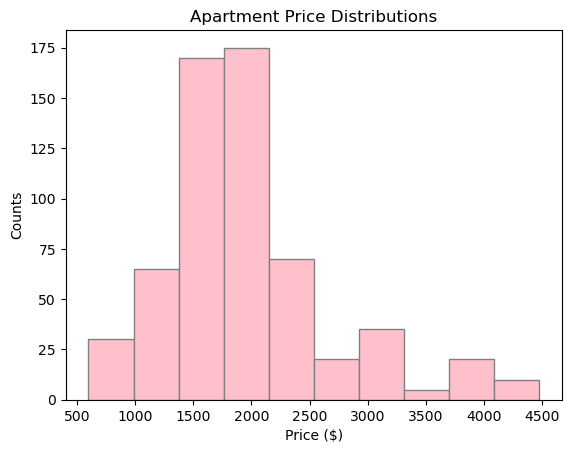

In [293]:
plt.title('Apartment Price Distributions')
plt.hist(results['price'], color='pink', edgecolor='grey')
plt.xlabel('Price ($)')
plt.ylabel('Counts')
plt.show()

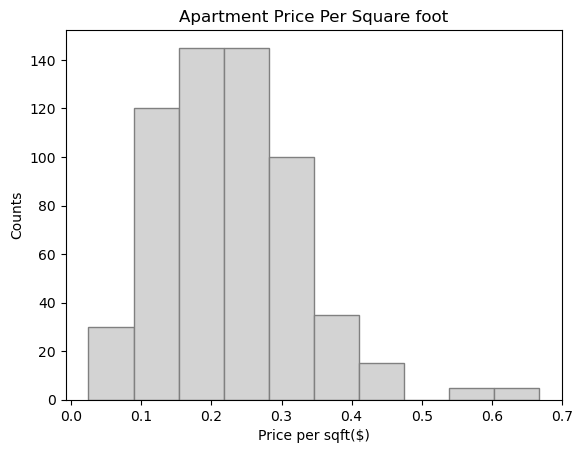

In [299]:
results['pricepersq'] = results['price'] / results['size']

plt.title('Apartment Price Per Square foot')
plt.hist(results['pricepersq'], color='lightgrey', edgecolor='grey')
plt.xlabel('Price per sqft($)')
plt.ylabel('Counts')
plt.show()


#### Side note: rental prices per sq. ft. from Craigslist

The histogram of price per sq ft should be centered around ~1.5. Here is a plot of how Philadelphia's rents compare to the other most populous cities:

<img src="imgs/rental_prices_psf.png" width=600/>

[Source](https://arxiv.org/pdf/1605.05397.pdf)

### 2.8 Comparing prices for different sizes 

Use `altair` to explore the relationship between price, size, and number of bedrooms. Make an interactive scatter plot of price (x-axis) vs. size (y-axis), with the points colored by the number of bedrooms. 

Make sure the plot is interactive (zoom-able and pan-able) and add a tooltip with all of the columns in our scraped data frame.

With this sort of plot, you can quickly see the outlier apartments in terms of size and price.

In [305]:
chart = alt.Chart(results)
chart = chart.mark_circle(size=40)
chart = chart.encode(
    x = "price:Q",
    y = "size:Q",
    color = "bedrooms:N",
    tooltip = ["title", "price", "size", "bedrooms"],
)

chart.interactive()



alt.Chart(...)